### Tester for float_mix_functions.conservative_to_pT_WLMA_bn and related

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light

# Cython-backend imports
import float_phi_functions
import float_mix_functions
import iapws95_light_perf
import mixtureWLMA
from time import perf_counter
import scipy.optimize

wlma = mixtureWLMA.WLMA()
K = wlma.K
p_m0 = wlma.p_m0
rho_m0 = wlma.rho_m0
v_m0 = 1.0 / rho_m0
c_v_m0 = wlma.c_v_m0
R_a = wlma.R_a
gamma_a = wlma.gamma_a
rhoc = mixtureWLMA.rhoc
Tc = mixtureWLMA.Tc

def prim_to_cons(yw, T, rhow, ya):
  ''' Map from known primitive quantities to set of conservative variables.'''
  p_target = float_phi_functions.p(rhow, T)
  if p_target < 1e5 or p_target > 100e6:
    # Skip
    return (np.nan, np.nan, np.nan)
  rhom = rho_m0* (1.0 + (p_target - p_m0) / K)
  rhoa = p_target / (R_a * T)
  rho_mix = 1.0/(yw / rhow + (1 - yw - ya) / rhom + ya / rhoa)
  uw_target = float_phi_functions.u(rhow, T)
  um_target = c_v_m0 * T \
    + float_mix_functions.magma_mech_energy(p_target, K , p_m0, rho_m0)
  ua_target = R_a / (gamma_a - 1.0) * T
  u_target = yw*uw_target + (1-yw-ya)*um_target + ya*ua_target
  vol_energy = rho_mix * u_target
  return (vol_energy, rho_mix, p_target)

#### Spot test

In [2]:
""" Spot test """
vol_energy, rho_mix, yw, ya = (3047131395.430944, 2598.3294372189876, 1e-07, 1e-07)

params = {
  "vol_energy": vol_energy,
  "rho_mix": rho_mix,
  "yw": yw,
  "ya": ya,
  "K": K,
  "p_m0": p_m0,
  "rho_m0": rho_m0,
  "c_v_m0": c_v_m0,
  "R_a": R_a,
  "gamma_a": gamma_a,
}

# Create simple global logger
class SimpleLogger():
  def __init__(self):
    self.curr_log = []
    self.all_logs = [self.curr_log]
  def log(self, level, data):
    self.curr_log.append((level, data))
  def create_new_log(self):
    self.curr_log = []
    self.all_logs.append(self.curr_log)
  def pop_log(self):
    return self.all_logs.pop()
logger = SimpleLogger()

# Single backtrack step
float_mix_functions.iterate_backtrack_box(0.5, 600, params, logger=False)

float_mix_functions.conservative_to_pT_WLMA_bn(
  vol_energy, rho_mix, yw, ya,
  K, p_m0, rho_m0, c_v_m0,
  R_a, gamma_a, logger=logger)

{'rhow': 70.09333333260602, 'p': 184976.5440599357, 'T': 390.909090909091}

#### Grid test

In [3]:
# Set test range
vec_yw = np.logspace(np.log10(1e-7), np.log10(1-1e-7), 40) #np.linspace(1e-6, 1-1e-7, 24) # 125
vec_T = np.linspace(273.16+5, 1500, 96) # 130
vec_rhow = np.linspace(0.1, 1260, 48) # 60
vec_ya = np.linspace(1e-7, 1-1e-7, 52)

mg_yw, mg_T, mg_rhow, mg_ya = np.meshgrid(
  vec_yw, vec_T, vec_rhow, vec_ya, indexing="ij")

mg_p_target = np.zeros_like(mg_yw)
mg_vol_energy = np.zeros_like(mg_yw)
mg_rho_mix = np.zeros_like(mg_yw)

# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(mg_yw.shape):
  if mg_ya[i,j,k,l] + mg_yw[i,j,k,l] <= 1.0:
    mg_vol_energy[i,j,k,l], mg_rho_mix[i,j,k,l], mg_p_target[i,j,k,l] = \
      prim_to_cons(mg_yw[i,j,k,l], mg_T[i,j,k,l], mg_rhow[i,j,k,l], mg_ya[i,j,k,l])

# Allocate output memory
mg_p_calc = np.empty_like(mg_yw)
mg_T_calc = np.empty_like(mg_yw)


In [4]:
_logger = SimpleLogger()
# Remove the first entry
_logger.pop_log()

for i, j, k, l in np.ndindex(mg_yw.shape):
  _logger.create_new_log()
  # Skip nan inputs
  if np.isnan(mg_yw[i,j,k,l]) \
      or np.isnan(mg_vol_energy[i,j,k,l]) \
      or np.isnan(mg_rho_mix[i,j,k,l]):
    mg_p_calc[i,j,k,l] = 0.0
    mg_T_calc[i,j,k,l] = 0.0
    continue
  # Redefine kernel
  vol_energy = mg_vol_energy[i,j,k,l]
  rho_mix = mg_rho_mix[i,j,k,l]
  yw = mg_yw[i,j,k,l]
  ya = mg_ya[i,j,k,l]
  # Call compute without logging
  _rhopT = float_mix_functions.conservative_to_pT_WLMA_bn(
    vol_energy, rho_mix, yw, ya,
    K, p_m0, rho_m0, c_v_m0,
    R_a, gamma_a, logger=_logger)
  mg_p_calc[i,j,k,l], mg_T_calc[i,j,k,l] = _rhopT["p"], _rhopT["T"]

#### Vectorizing interface test

Compute error using the vectorizing interface `float_mix_functions.vec_conservative_to_pT_WLMA`

Text(0, 0.5, 'Relative error in pressure')

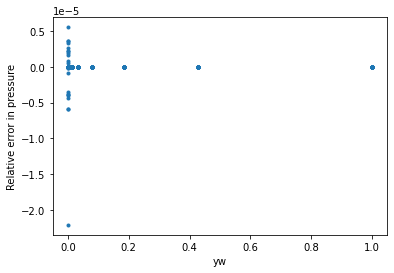

In [4]:
# Set test range
short_vec_yw = np.logspace(np.log10(1e-7), np.log10(1-1e-7), 20) #np.linspace(1e-6, 1-1e-7, 24) # 125
short_vec_T = np.linspace(273.16+5, 1500, 36) # 130
short_vec_rhow = np.linspace(0.1, 1260, 32) # 60
short_vec_ya = np.linspace(1e-7, 1-1e-7, 24)

short_mg_yw, short_mg_T, short_mg_rhow, short_mg_ya = np.meshgrid(
  short_vec_yw, short_vec_T, short_vec_rhow, short_vec_ya, indexing="ij")

short_mg_p_target = np.nan * np.zeros_like(short_mg_yw)
short_mg_vol_energy = np.nan * np.zeros_like(short_mg_yw)
short_mg_rho_mix = np.nan * np.zeros_like(short_mg_yw)

# Iteratively load complete conservative state
for i, j, k, l in np.ndindex(short_mg_yw.shape):
  if short_mg_ya[i,j,k,l] + short_mg_yw[i,j,k,l] <= 1.0:
    (short_mg_vol_energy[i,j,k,l],
     short_mg_rho_mix[i,j,k,l],
     short_mg_p_target[i,j,k,l]) = prim_to_cons(
      short_mg_yw[i,j,k,l],
      short_mg_T[i,j,k,l],
      short_mg_rhow[i,j,k,l],
      short_mg_ya[i,j,k,l])

# Allocate output memory
# mg_p_calc = np.empty_like(mg_yw)
# mg_T_calc = np.empty_like(mg_yw)
valid_indices = np.where((~np.isnan(short_mg_vol_energy.ravel())) & (short_mg_vol_energy.ravel() != 0))
# Simulate vector input
vec_in_vol_energy = short_mg_vol_energy.ravel()[valid_indices]
vec_in_rho_mix = short_mg_rho_mix.ravel()[valid_indices]
vec_in_yw = short_mg_yw.ravel()[valid_indices]
vec_in_ya = short_mg_ya.ravel()[valid_indices]

vec_in_vol_energy0 = vec_in_vol_energy.copy()
_out = float_mix_functions.vec_conservative_to_pT_WLMA(vec_in_vol_energy, vec_in_rho_mix, vec_in_yw, vec_in_ya, K, p_m0, rho_m0,
  c_v_m0, R_a, gamma_a, logger=False)

# Compute relative errors of vectorized wrapper
_vec_rels = _out[1::4] / short_mg_p_target.ravel()[valid_indices] - 1.0
plt.plot(short_mg_yw.ravel()[valid_indices], _vec_rels, '.')
plt.xlabel("yw")
plt.ylabel("Relative error in pressure")

Timing for computing through the vectorizing interface

In [5]:
''' Timing '''
import timeit
N_runs = 2
timing = timeit.timeit(lambda: float_mix_functions.vec_conservative_to_pT_WLMA(
  vec_in_vol_energy, vec_in_rho_mix, vec_in_yw, vec_in_ya,
  K, p_m0, rho_m0, c_v_m0, R_a, gamma_a, logger=False), number=N_runs)
wall_per_input_ms = timing / (N_runs * vec_in_vol_energy.size) * 1e3
print(f"Timing: {wall_per_input_ms} ms average per input")

Timing: 0.12529006683716964 ms average per input


In [6]:
''' Construct Quail-like input for testing Quail interface. '''
quail_like_arho_vec = vec_in_rho_mix.reshape((-1,1,1)) * np.concatenate((
  vec_in_ya.reshape((-1,1,1)),
  vec_in_yw.reshape((-1,1,1)),
  (1-(vec_in_ya+vec_in_yw)).reshape((-1,1,1)),), axis=-1)
quail_like_momentum = np.zeros_like(quail_like_arho_vec[...,0:2])
quail_like_vol_energy = vec_in_vol_energy.reshape((-1,1,1))

In [7]:
_t1 = perf_counter()
serial_out = wlma.WLM_rhopT_native(quail_like_arho_vec, quail_like_momentum, quail_like_vol_energy)
_t2 = perf_counter()
wlma_par = mixtureWLMA.WLMA(num_parallel_workers=4)
_t3 = perf_counter()
par_out = wlma_par.WLM_rhopT_native(quail_like_arho_vec, quail_like_momentum, quail_like_vol_energy)
_t4 = perf_counter()

print(f"Serial: {_t2 - _t1} s")
print(f"Parallel: {_t4 - _t3} s")
print(f"1/n Scaling: {(_t2 - _t1)/4} s")

Serial: 18.48980810000002 s
Parallel: 5.409904900000015 s
1/n Scaling: 4.622452025000005 s


In [8]:
len(serial_out)

5

In [12]:
# rhow, p, T, sound_speed, volfracW
# %timeit len(list(zip(*par_out)))
def __():
  return [np.concatenate(par_output, axis=0) for par_output in (zip(*par_out))]
def ___():
  a,b,c,d,e = __()
%timeit ___()

ValueError: too many values to unpack (expected 5)

In [9]:
''' Testing Pool() construction overhead
Note that mp.map and similar methods may not work in ipynb.
'''
import multiprocessing as mp
_t5 = perf_counter()
with mp.Pool(3) as _p:
  ''' pass '''
_t6 = perf_counter()
_t6 - _t5

0.016004200000224955

#### Hit count testing

In [5]:
""" Get hit counts from logs """
hit_counts = [0] * (8+1)
for i in range(len(_logger.all_logs)):
  if _logger.all_logs[i]:
    hit_counts[_logger.all_logs[i][0][1].get("alphaw_argmin", -1)] += 1

NameError: name '_logger' is not defined

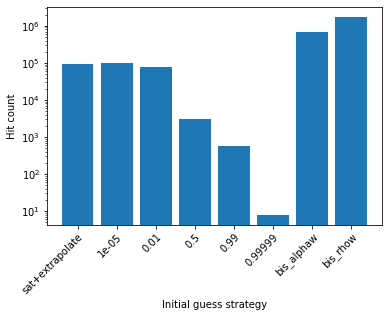

In [ ]:
# Plot hit count histogram
fig, ax = plt.subplots()
# Create bar
ax.bar(list(range(8)), hit_counts[:-1], log=True)
ax.set_xlabel("Initial guess strategy")
ax.set_ylabel("Hit count")
# Define labels
labels = ["sat+extrapolate", 1e-5, 0.01, 0.5, 0.99, 1.0-1e-5, "bis_alphaw", "bis_rhow"]

# Label bars on x-axis
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
# Rotate labels
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#### Num steps logged testing

In [ ]:
""" Get log count from logs as proxy for function call count """
log_counts = [len(log) for log in _logger.all_logs]

Text(0.5, 0, 'Number of steps logged')

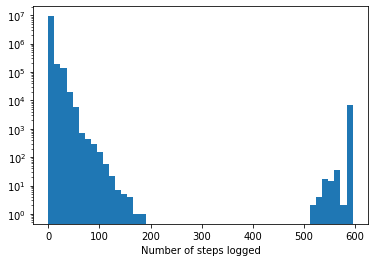

In [ ]:
plt.hist(log_counts, log=True, bins=50)
plt.xlabel("Number of steps logged")

In [ ]:
""" Pull one nonempty log """
# _logger.all_logs[83642]

' Pull one log '

In [ ]:
# Save log (not recommended, huge file)
# # import pickle
# with open('log0.pkl', 'wb') as handle:
#   pickle.dump(_logger, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Vector-level parallelism

In [6]:
import multiprocessing as mp

NUM_WORKERS = 2
pool = mp.Pool(NUM_WORKERS)

def task(vec_in_vol_energy, vec_in_rho_mix, vec_in_yw, vec_in_ya):
  ''' Curried task '''
  return float_mix_functions.vec_conservative_to_pT_WLMA(
    vec_in_vol_energy, vec_in_rho_mix, vec_in_yw, vec_in_ya,
    K, p_m0, rho_m0, c_v_m0, R_a, gamma_a, logger=False)
pool.starmap(task,
  zip(np.array_split(vec_in_vol_energy, NUM_WORKERS),
    np.array_split(vec_in_rho_mix, NUM_WORKERS),
    np.array_split(vec_in_yw, NUM_WORKERS),
    np.array_split(vec_in_ya, NUM_WORKERS))
)

In [ ]:
vec_in_vol_energy

#### Plot errors

For calibration:
* Note that for T above 1720 K ~ 1760 K: weird things happen
* T too close to triple point is also dangerous

C:\Users\Fredric\AppData\Local\Temp\ipykernel_9360\2014913622.py:3: RuntimeWarning: invalid value encountered in true_divide
  p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)


Text(0.5, 0, '')

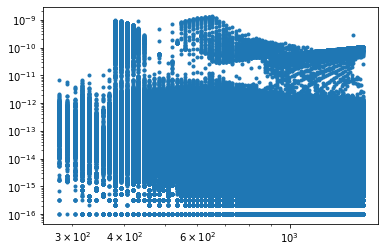

In [ ]:
%matplotlib inline
p_diffs = np.abs(mg_p_calc - mg_p_target)
p_reldiffs = np.abs(mg_p_calc / mg_p_target - 1.0)
# plt.loglog((1 - mg_yw - mg_ya)[np.where(~np.isnan(p_reldiffs))], 1e-16+p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')
# Transform to liquid volfrac
mg_alpham = mg_rho_mix * (1 - mg_yw - mg_ya) / (rho_m0 * (1.0 + (mg_p_target - p_m0) / K))
# plt.loglog(mg_alpham[np.where(~np.isnan(p_reldiffs))], 1e-16+p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')
plt.loglog(mg_T[np.where(~np.isnan(p_reldiffs))], 1e-16+p_reldiffs[np.where(~np.isnan(p_reldiffs))], '.')
plt.xlabel("")